# Transfer Learning(전이학습)

## Transfer learning 이란
- 큰 데이터 셋에서 학습된 pre-trained network의 weight를 사용하여 다른 예측문제에 활용 
    - 예) 동물과 일상과 관련된 사물을 분류하는 ImageNet data를 학습시킨 VGG16 네트워크의 일부를 사용하여 가구 종류를 분류하는 네트워크 학습에 활용 
- Convolution base만 활용
    - Feature Extraction(Convolution base) 부분은 사진에 나타나는 일반적인 개체의  특성을 파악하기 위한 feature extraction의 결과물 
    - Classifier(Fully connected layer) 부분은 분류 목적에 맞게 특성화 된 부분
- 기존 모형이 학습한 데이터와 많이 다른 데이터에 적용하기 위해서는 앞의 몇 개 layer만 사용하는 것이 더 나음 
    - 앞 쪽의 layer은 지엽적이고 일반적인 feature map(e.g. visual edges, colors, and textures)
    - 더 깊은 부분의 layer는 보다 추상화된 feature map(e.g. "cat ear", "dog eye")
- 두 가지 방법 (1) Feature extraction, (2) Fine tuning 을 소개

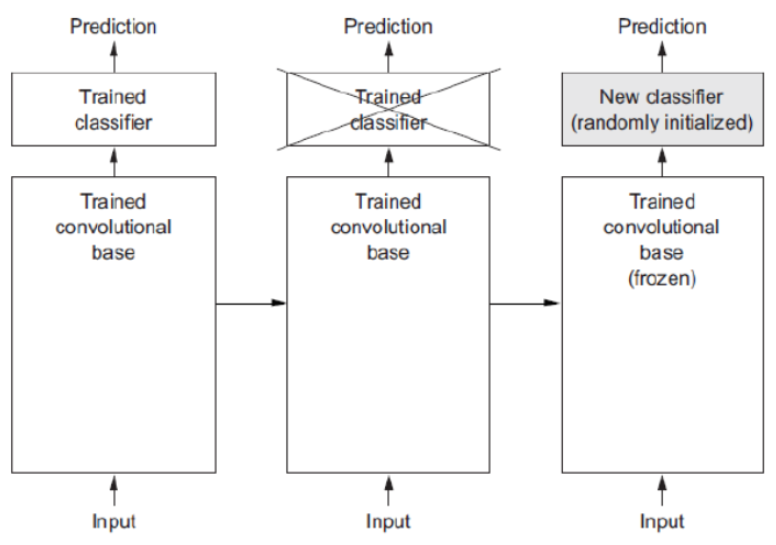

##  Feature extraction
- 기존의 학습된 network에서 fully connected layer를 제외한 나머지 weight를 고정하고 새로운 목적에 맞는 fully connected layer를 추가하여 추가된 weight만 학습하는 방법
- `tensorflow.keras.applications` module이 지원하는  image classification models
    - Xception
    - VGG16
    - VGG19
    - ResNet50
    - InceptionV3
    - InceptionResNetV2
    - MobileNet
    - DenseNet
    - NASNet
    - MobileNetV2
    
    (https://www.tensorflow.org/api_docs/python/tf/keras/applications)    






##  VGG16 모델
- ImageNet ILSVRC Challenge 2014에서 2등한 모델로 Simonyan and Zisserman(Oxford Univ.)에 의해 제안
    - VGGNet이 준우승을 하긴 했지만, 구조의 간결함과 사용의 편이성으로 인해 1등한 GoogLeNet보다 더 각광받았다
- 단순한 구조로 지금까지 많이 사용.
- 총 16개 layer로 구성되됨. 
- Filter의 수가 64, 128, 256,512 두 배씩 커짐 
- 항상 $3 \times 3$ filter, Stride=1, same padding, $2\times 2$ MaxPooling 사용
- 약 1억4천만 개의 parameter(가중치): 매우 많은 메모리와 연산량이 필요

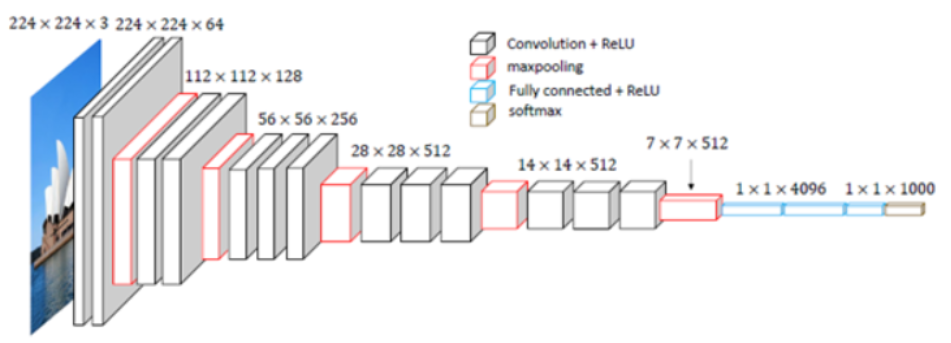

- VGG16()
    - Imagenet의 1000개의 카테고리를 분류하는 문제에 학습된 VGG16의 network와 weight를 불러옴 
    - 매개변수
        - `weights`: 모형의 weight의 초기값 
        - `include_top`: fully connected classifier를 포함할지 여부. True 포함시킴, False: 포함 안 시킴
        - `input_shape`: 사용자가 입력할 이미지의 크기 shape. 3D 텐서로 지정. (높이, 너비, 채널). 기본값 (224, 224, 3) (VGG16에서 정한 사이즈)


In [2]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,  #top을 안가져 오겠다.=>convolution만 가져오겠다. (dense는 안가져 온다.)
                  input_shape=(150, 150, 3))   

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Feature extraction의 두 가지 방법
1. **빠른 추출방식**
    - 예측하려는 새로운 데이터를 위의 `conv_base`에 입력하여 나온 출력값을 numpy 배열로 저장하고 이를 분류 모델의 입력값으로 사용. Convolution operation을 하지 않아도 되기 때문에 빠르게 학습. 하지만 data augmentation 방법을 사용할 수 없음.

2. **받아온 특성 Layer를 이용해 새로운 모델 구현하는 방식**
    - 위의 `conv_base` 이후에 새로운 layer를 쌓아 확장한 뒤 전체 모델을 다시 학습. 모든 데이터가 convolution layer들을 통과해야 하기 때문에 학습이 느림. 단 conv_base의 가중치는 업데이트 되지 않도록 한다. data augmentation 방법을 사용할 수 있음.

### 빠른 특성 추출 방식


- `conv_base`의 predict 메소드로 입력 이미지의 feature를 추출 

In [4]:
# train, validation, test 이미지가 들어있는 폴더 경로를 지정
train_dir = './data/cats_and_dogs_small/train'
validation_dir = './data/cats_and_dogs_small/validation'
test_dir = './data/cats_and_dogs_small/test'

In [7]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    """
    디렉토리로 부터 Image들을 읽어 들여 VGG16의 특성추출 레이어를 이용해 이미지 특성 추출
    directory: 이미지를 가져올 디렉토리
    sample_count: 학습시킬 이미지 개수
    """
#   추출된 이미지 특성들을 저장할 ndarray변수.  array 크기: (개수, conv_base의 출력 shape)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
#   label을 저장할 변수
    labels = np.zeros(shape=(sample_count))
    
    # ImageDataGenerator를 이용해 이미지 가져오기.
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0 #predict한 이미지 수를 저장해 sample_count보다 커지면 break 한다.
    for inputs_batch, labels_batch in generator:
        #VGG16을 통해 나오는 특성맵을 저장
        feature_map_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = feature_map_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
train_features.shape, train_labels.shape

((2000, 4, 4, 512), (2000,))

- 출력된 feature가 4D array이기 때문에 새로운 DNN 모델에 입력으로 넣기 위해 2D array로 변환 (개수, feature) 

In [10]:
train_features = train_features.reshape((2000, 4 * 4 * 512))
validation_features = validation_features.reshape((1000, 4 * 4 * 512))
test_features = test_features.reshape((1000, 4 * 4 * 512))

In [11]:
train_features.shape

(2000, 8192)

- 분류(Classification) 모델 구현 및 학습

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(4 * 4 * 512,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(lr=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.6935 - accuracy: 0.5720 - val_loss: 0.5497 - val_accuracy: 0.7910
Epoch 2/30
2000/2000 [==============================] - 1s 279us/sample - loss: 0.5419 - accuracy: 0.7290 - val_loss: 0.4696 - val_accuracy: 0.8140
Epoch 3/30
2000/2000 [==============================] - 1s 275us/sample - loss: 0.4698 - accuracy: 0.7880 - val_loss: 0.4088 - val_accuracy: 0.8620
Epoch 4/30
2000/2000 [==============================] - 1s 278us/sample - loss: 0.4064 - accuracy: 0.8225 - val_loss: 0.3748 - val_accuracy: 0.8620
Epoch 5/30
2000/2000 [==============================] - 1s 285us/sample - loss: 0.3723 - accuracy: 0.8445 - val_loss: 0.3489 - val_accuracy: 0.8790
Epoch 6/30
2000/2000 [==============================] - 1s 281us/sample - loss: 0.3430 - accuracy: 0.8585 - val_loss: 0.3316 - val_accuracy: 0.8870
Epoch 7/30
2000/2000 [==============================] - 1s 287us/s

In [16]:
import matplotlib.pyplot as plt

def fit_result_graph(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()    

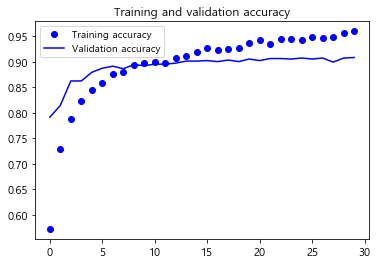

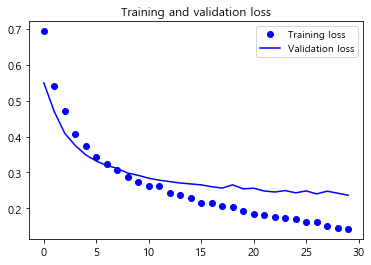

In [17]:
fit_result_graph(history, 30)

- 학습 속도가 매우 빠름
- 90% 정도의 validation accuracy에 도달함
- 이미지 증식을 하지 않았기 때문에 overfitting이 발생함 

### 받아온 특성 Layer를 이용해 새로운 모델 구현하는 방식

- VGG16의 network에 fully connected layer를 추가하여 모형 생성 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import optimizers

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


- Network의 모든 weight가 학습되는 모형임
- VGG16에서 가져온 부분은 학습을 하지 않고 weight를 고정시킬 것이므로 아래와 같이  **trainable=False**를 설정

In [20]:
conv_base.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


- `Non-trainable params`의 수가 `vgg16` layer의 parameter 수와 동일함을 확인

### ImageDataGenerator를 이용해 이미지 augmentation

In [21]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

# Test set은 Augmentation을 해선 안된다. 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [35]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

In [36]:
history = model.fit_generator(train_generator,
                          steps_per_epoch=100,
                          epochs=5, # 느린 학습속도 때문에 예시로 5 epoch만 학습
                          validation_data=validation_generator,
                          validation_steps=50)

Epoch 1/5
100/100 [==============================] - 105s 1s/step - loss: 0.4729 - accuracy: 0.7755 - val_loss: 0.3080 - val_accuracy: 0.8620
Epoch 2/5
100/100 [==============================] - 473s 5s/step - loss: 0.3393 - accuracy: 0.8425 - val_loss: 0.2248 - val_accuracy: 0.9050
Epoch 3/5
100/100 [==============================] - 473s 5s/step - loss: 0.3031 - accuracy: 0.8765 - val_loss: 0.1886 - val_accuracy: 0.9200
Epoch 4/5
100/100 [==============================] - 473s 5s/step - loss: 0.2659 - accuracy: 0.8900 - val_loss: 0.2217 - val_accuracy: 0.9070
Epoch 5/5
100/100 [==============================] - 473s 5s/step - loss: 0.2363 - accuracy: 0.9015 - val_loss: 0.2605 - val_accuracy: 0.9000


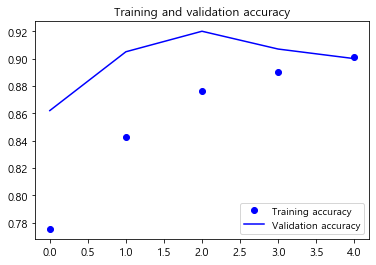

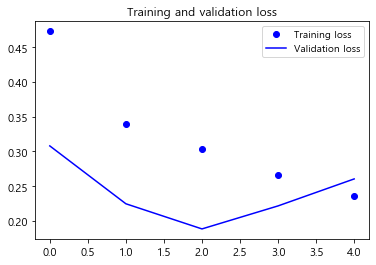

In [37]:
fit_result_graph(history, 5)

- `conv_base`에 해당하는 weight를 학습하지는 않지만 새로운 이미지 학습데이터가 VGG16의 모든 convolution layer를 통과해야 하기 때문에 학습속도가 이전에 비해 현저히 느림
- Data augmentation을 통해 overfitting 방지 효과가 있음


## 미세조정(Fine-tuning)
- 기존 network에서 가져온 base에 사용자의 목적에 맞는 dense layer를 추가하는 부분은 이전과 동일 
- Base model의 weight을 모두 고정하지 않고 일부 top layer를 학습과정에서 함께 업데이트
- 주어진 문제에 더 적합하도록 모형을 조정하는 과정 

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [38]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [39]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### conv_base 중 Parameter를 학습시킬 layer선택
- **model.layers** 속성: model을 구성하는 layer들을 list로 반환

In [40]:
conv_base.layers

- 가장 뒤에 있는 `block5_conv1`, `block5_conv2`,  `block5_conv3`를 fine-tune 시도 
    - 앞의 layer들은 비교적 일반적이고 재사용 가능한 feature를 학습
    - 너무 많은 parameter를 학습시키면 overfitting의 위험이 있음 (특히 새로운 데이터의 수가 적을 때)

In [41]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

history2 = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 397s 4s/step - loss: 0.3158 - accuracy: 0.8555 - val_loss: 0.5548 - val_accuracy: 0.8260
Epoch 2/30
100/100 [==============================] - 472s 5s/step - loss: 0.2711 - accuracy: 0.8845 - val_loss: 0.1751 - val_accuracy: 0.9230
Epoch 3/30
100/100 [==============================] - 472s 5s/step - loss: 0.2041 - accuracy: 0.9180 - val_loss: 0.1597 - val_accuracy: 0.9350
Epoch 4/30
100/100 [==============================] - 472s 5s/step - loss: 0.1792 - accuracy: 0.9330 - val_loss: 0.1692 - val_accuracy: 0.9280
Epoch 5/30
100/100 [==============================] - 472s 5s/step - loss: 0.1726 - accuracy: 0.9220 - val_loss: 0.1655 - val_accuracy: 0.9340
Epoch 6/30
100/100 [==============================] - 472s 5s/step - loss: 0.1671 - accuracy: 0.9360 - val_loss: 0.1624 - val_accuracy: 0.9350
Epoch 7/30
100/100 [==============================] - 472s 5s/step - loss: 0.1427 - accuracy: 0.9410 - val_loss: 0.1704 - val_accuracy: 0.9340

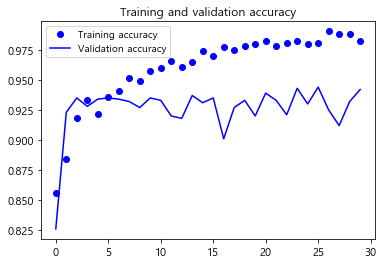

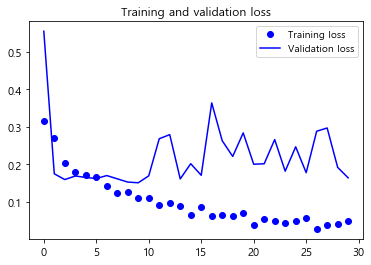

In [45]:
fit_result_graph(history2, 30)

In [47]:
model.evaluate_generator(test_generator, steps=50)

[0.2197987438295968, 0.945]